# Import the package

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from matplotlib.pyplot import MultipleLocator
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from matplotlib.pyplot import MultipleLocator
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from datetime import datetime

# Read the data from csv file

In [2]:
arrhyData=pd.read_csv('arrhythmia data with title.csv')
arrhyData.head()

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,Q wave V6,R wave V6,S wave V6,R' wave V6,S' wave V6,P wave V6,T wave V6,QRSA V6,QRSTA V6,label
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [3]:
arrhyData.shape

(452, 280)

<AxesSubplot:xlabel='label', ylabel='count'>

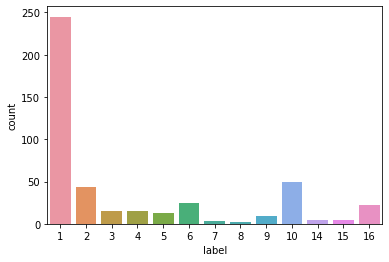

In [4]:
sns.countplot(x='label',data=arrhyData)

# Explore the data distribution

True     245
False    207
Name: label, dtype: int64
       label
True     245
False    207
       label        Type
True     245      normal
False    207  arrhythmia
Index(['label', 'Type'], dtype='object')


<AxesSubplot:xlabel='Type', ylabel='Count'>

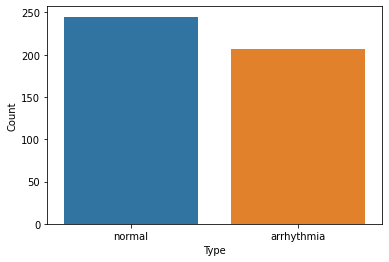

In [5]:
type=pd.value_counts(arrhyData['label']==1)
print(type)
count_df = type.to_frame()
print(count_df)
count_df['Type'] = ['normal','arrhythmia']
print(count_df)

df_new = count_df.rename(columns={'label': 'Count'})
print( count_df.columns)
sns.barplot(y= 'Count',x='Type', data=df_new)
#print(arrhyData)


In [6]:
df_new

,Count,Type
True,245,normal
False,207,arrhythmia


In [7]:
arrhyData['type']=np.where(arrhyData["label"]==1,'Normal','Abnormal') 

B:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

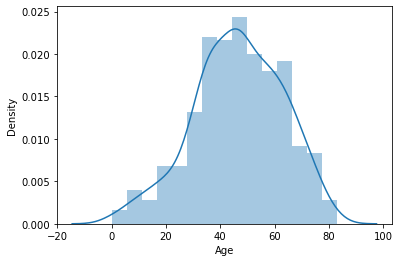

In [8]:
sns.distplot(arrhyData['Age'])

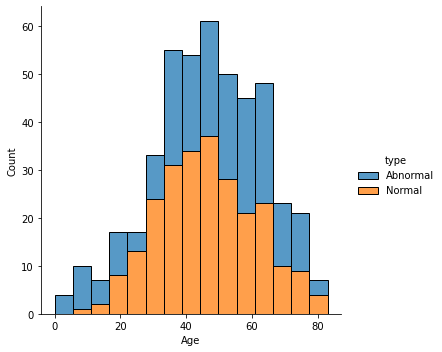

In [9]:
sns.displot(arrhyData, x="Age", hue="type", multiple="stack")

In [10]:
cats=pd.cut(arrhyData['Age'],[])

J              1.000000
JJ wave AVF    0.685795
Name: J, dtype: float64
J               1.000000
JJ wave AVF     0.685795
JJ wave DIII    0.657752
Name: J, dtype: float64


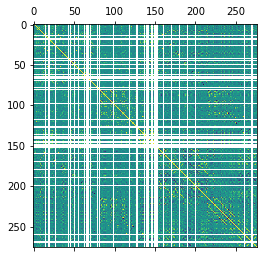

In [11]:
filterData=arrhyData[arrhyData['J']!='?']
filterData = filterData.astype({'J': 'int32'})

#print(filterData['J'])
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#for c in filterData.corr().columns:
   # print (c)
print(filterData.corr()['J'].nlargest(2))
print(filterData.corr()['J'].nlargest(3))
plt.matshow(filterData.corr())
plt.show()

# Detect the miss value

In [12]:
pd.value_counts(pd.isnull(arrhyData['Age']))

False    452
Name: Age, dtype: int64

In [13]:
num=pd.value_counts((arrhyData['J']=='?'))
print(num)
resultJ=num.get(True)
print(resultJ)
percentJ=resultJ/452

print(percentJ)

True     376
False     76
Name: J, dtype: int64
376
0.831858407079646


In [14]:
num=pd.value_counts((arrhyData['P']=='?'))
print(num)
resultP=num.get(True)
print(resultP)
percentP=resultP/452

print(percentP)

False    430
True      22
Name: P, dtype: int64
22
0.048672566371681415


In [15]:
num=pd.value_counts((arrhyData['T']=='?'))
print(num)
resultT=num.get(True)
print(resultT)
percentT=resultT/452

print(percentT)

False    444
True       8
Name: T, dtype: int64
8
0.017699115044247787


In [16]:
num=pd.value_counts((arrhyData['QRST']=='?'))
print(num)
resultQRST=num.get(True)
print(resultQRST)
percentQRST=resultQRST/452

print(percentQRST)

False    451
True       1
Name: QRST, dtype: int64
1
0.0022123893805309734


In [17]:
#def turn_percentage(x):
#    return '%.2f%%'%(x*100)

num=pd.value_counts((arrhyData['Heart rate']=='?'))
print(num)
resultHR=num.get(True)
print(resultHR)
percentHR=resultHR/452


print(percentHR)

False    451
True       1
Name: Heart rate, dtype: int64
1
0.0022123893805309734


In [18]:
cloumnloss={'losspercent':[percentJ,percentP,percentT,percentQRST,percentHR],
            'lossdata':[resultJ,resultP,resultT,resultQRST,resultHR],
            'columnname':['J_angle','P_angle','T_angle','QRST_angle','Heart_beat']
           }

print(cloumnloss)
frame=pd.DataFrame(cloumnloss)
frame['losspercent']=frame['losspercent'].apply(lambda x:format(x,'.2%'))
print(frame)

{'losspercent': [0.831858407079646, 0.048672566371681415, 0.017699115044247787, 0.0022123893805309734, 0.0022123893805309734], 'lossdata': [376, 22, 8, 1, 1], 'columnname': ['J_angle', 'P_angle', 'T_angle', 'QRST_angle', 'Heart_beat']}
  losspercent  lossdata  columnname
0      83.19%       376     J_angle
1       4.87%        22     P_angle
2       1.77%         8     T_angle
3       0.22%         1  QRST_angle
4       0.22%         1  Heart_beat


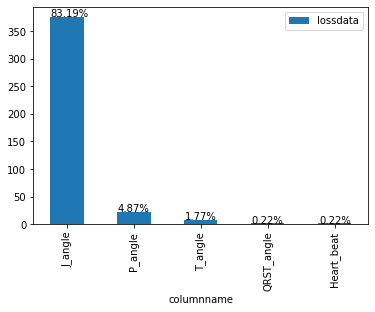

In [19]:
#sns.barplot(y= 'lossdata',x='columnname', data=frame)
ax=frame.plot(x='columnname',y= 'lossdata',kind='bar')
#print(frame['losspercent'][0])
for i, p in enumerate(ax.patches):
    
#i=0
#for p in ax.patches:   
    
    ax.annotate(frame['losspercent'][i], (p.get_x() * 1.005, p.get_height() * 1.005))
#   i=i+1
#for i in 'columnname':
   #g.text('columnname','losspercent', 'lossdata')

In [20]:
arrLoss=arrhyData.replace('?', np.nan)

In [21]:
def missing_count(df):
    nan_count=df.isnull().sum()
    nan_count=nan_count[nan_count>0].sort_values()
    return nan_count
print(missing_count(arrLoss))  
mcarrLoss=missing_count(arrLoss)
                   

QRST            1
Heart rate      1
T               8
P              22
J             376
dtype: int64


In [22]:
def missing_percent(df):
    nan_percent=df.isnull().sum()
    nan_percent=100*((nan_percent[nan_percent>0])/len(df)).sort_values()
    return nan_percent
print(missing_percent(arrLoss)) 
mcarrLossPer=missing_percent(arrLoss)

QRST           0.221239
Heart rate     0.221239
T              1.769912
P              4.867257
J             83.185841
dtype: float64


In [23]:
arrLoss['QRST'].dtype
# arrLoss['Heart rate'].dtype
# arrLoss['T'].dtype
# arrLoss['P'].dtype
# arrLoss['J'].dtype

dtype('O')

# Fulfill the miss value

In [24]:
arrFilled=arrLoss.fillna(method='ffill')
arrFilled

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,R wave V6,S wave V6,R' wave V6,S' wave V6,P wave V6,T wave V6,QRSA V6,QRSTA V6,label,type
0,75,0,190,80,91,193,371,174,121,-16,...,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8,Abnormal
1,56,1,165,64,81,174,401,149,39,25,...,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6,Abnormal
2,54,0,172,95,138,163,386,185,102,96,...,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10,Abnormal
3,55,0,175,94,100,202,380,179,143,28,...,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1,Normal
4,75,0,190,80,88,181,360,177,103,-16,...,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,1,Normal
448,37,0,190,85,100,137,361,201,73,86,...,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,10,Abnormal
449,36,0,166,68,108,176,365,194,116,-85,...,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,2,Abnormal
450,32,1,155,55,93,106,386,218,63,54,...,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,1,Normal


In [25]:
arrFilled=arrLoss.fillna(method='bfill')
arrFilled

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,R wave V6,S wave V6,R' wave V6,S' wave V6,P wave V6,T wave V6,QRSA V6,QRSTA V6,label,type
0,75,0,190,80,91,193,371,174,121,-16,...,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8,Abnormal
1,56,1,165,64,81,174,401,149,39,25,...,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6,Abnormal
2,54,0,172,95,138,163,386,185,102,96,...,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10,Abnormal
3,55,0,175,94,100,202,380,179,143,28,...,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1,Normal
4,75,0,190,80,88,181,360,177,103,-16,...,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,1,Normal
448,37,0,190,85,100,137,361,201,73,86,...,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,10,Abnormal
449,36,0,166,68,108,176,365,194,116,-85,...,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,2,Abnormal
450,32,1,155,55,93,106,386,218,63,54,...,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,1,Normal


In [26]:
arrFilled['J'] = arrFilled['J'].fillna('103')

In [27]:
arrFilled['QRST']=arrFilled['QRST'].astype(int)
arrFilled['Heart rate']=arrFilled['Heart rate'].astype(int)
arrFilled['T']=arrFilled['T'].astype(int)
arrFilled['P']=arrFilled['P'].astype(int)
arrFilled['J']=arrFilled['J'].astype(int)

In [28]:
arrFilled['QRST'].dtype

dtype('int32')

In [29]:
arrFilled['T'].dtype

dtype('int32')

In [30]:
print(missing_count(arrFilled))  

Series([], dtype: int64)


In [31]:
print(missing_percent(arrFilled)) 

Series([], dtype: float64)


In [32]:
arrFilled.shape

(452, 281)

In [33]:
arrFilled.dtypes

Age               int64
Sex               int64
Height            int64
Weight            int64
QRS duration      int64
                 ...   
T wave V6       float64
QRSA V6         float64
QRSTA V6        float64
label             int64
type             object
Length: 281, dtype: object

# Detect the small number of classes

In [34]:

y_train = np.array(arrFilled['label'])
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [35]:
y_train.shape

(452,)

In [36]:
y_count = np.bincount(y_train)
y_count

array([  0, 245,  44,  15,  15,  13,  25,   3,   2,   9,  50,   0,   0,
         0,   4,   5,  22], dtype=int64)

In [37]:
less_than_label=np.where(y_count<6)[0]
less_than_label

array([ 0,  7,  8, 11, 12, 13, 14, 15], dtype=int64)

In [38]:
for i in less_than_label:
    arrFilled1=arrFilled[~arrFilled['label'].isin ([i])]

In [39]:
arrFilled1.shape

(447, 281)

In [40]:
arrFilled2=arrFilled[~arrFilled.label.isin([0,7,8,11,12,13,14,15])]


In [41]:
set(arrFilled2['label'])

{1, 2, 3, 4, 5, 6, 9, 10, 16}

# Delete the large missed feature

In [42]:
arrFilled2=arrFilled2.drop(labels=['J'],axis=1)

In [43]:
arrFilled2.dtypes

Age               int64
Sex               int64
Height            int64
Weight            int64
QRS duration      int64
                 ...   
T wave V6       float64
QRSA V6         float64
QRSTA V6        float64
label             int64
type             object
Length: 280, dtype: object

# Rearrange the label

In [44]:
y1=arrFilled2['label'].values
y1 = LabelEncoder().fit_transform(y1)
arrFilled2['label']=y1

In [45]:
arrFilled2=arrFilled2.drop(labels=['type'],axis=1)

In [46]:
arrFilled2.head()

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,Q wave V6,R wave V6,S wave V6,R' wave V6,S' wave V6,P wave V6,T wave V6,QRSA V6,QRSTA V6,label
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,5
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,7
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,0
6,40,1,160,52,77,129,377,133,77,77,...,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5,0
7,49,1,162,54,78,0,376,157,70,67,...,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8,0


# Output the data after cleaning

In [47]:
arrFilled2.to_csv('Arrhythmia cleaned data.csv',index=False)